# Interactive tutorial: *extracting and sorting neural spikes*

***Disclosure***: this notebook is inspired from the following tutorial:
https://github.com/akcarsten/spike_sorting

Last week, we looked at how neural spikes influence the extracellular electric field, how they can be picked up by extracellular electrodes, and the challenges of discriminating spikes across different units (i.e., neurons) and noise.

Today, we will look at **signal processing methods** to **extract and classify spikes** from such electrical recordings. 

To this aim, we will use as our dataset a 30 min long recording from a single electrode implanted in an epilepsy patient. The dataset is freely accessible at:

https://leicester.figshare.com/articles/dataset/Dataset_Human_single-cell_recording/11302427/1

Before starting this tutorial, make sure to download the dataset archive and unzip it in a folder called `data/UCLA_data` inside this repository.

## Imports

In [1]:
import os
import numpy as np
from constants import *
from sigutils import *

## Step 1: Load the data

Let's start by loading the data (this may take a while).

In [2]:
fpath = './data/UCLA_data/CSC4.Ncs'
if not os.path.isfile(fpath):
    print('Fetching dataset from online archive...')
    ! bash ./postBuild
data = load_ncs_data(fpath)
fs = get_sampling_rate(data)
data

 13/02/2025 12:14:07: loading data from "./data/UCLA_data/CSC4.Ncs"...
 13/02/2025 12:14:07: sampling rate = 32.05 kHz
 13/02/2025 12:14:07: dataset is 00:31:43.22 s (61000192 samples) long


,time (s),Vraw
0,0.000000,385
1,0.000031,385
2,0.000062,380
3,0.000094,376
4,0.000125,374
...,...,...
61000187,1903.222583,-260
61000188,1903.222614,-251
61000189,1903.222645,-250
61000190,1903.222676,-265


Let's plot a chunk of signal to see what it looks like

 13/02/2025 12:14:08: plotting signals...


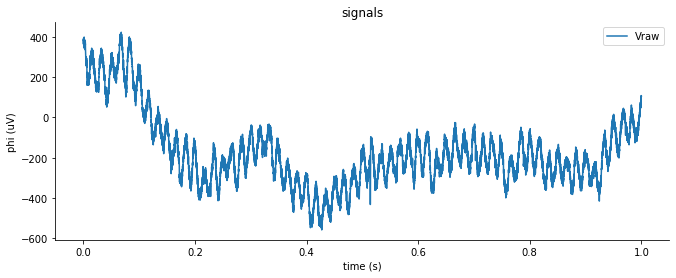

In [3]:
fig = plot_signals(data, tbounds=[0, 1])

### Questions:
- *At first glance, what can you say about this recording?*
- *Do you see any obvious spikes?* 

To get a better idea of the different components at play in the signal, let's plot its frequency spectrum

 13/02/2025 12:14:09: extracting and plotting Vraw frequency sectrum...


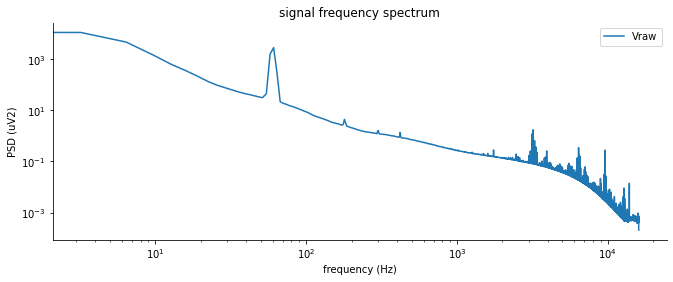

In [4]:
fig = plot_frequency_spectrum(data)

### Questions:

- *What can you say about the different frequency components of the recording?* 
- *In light of what you know about action potential dynamics, what is our frequency range of interest?*

## Step 2: denoise the data

As we've seen in the previous sessions, action potentials are typically 1-2 ms long, which corresponds a "fundamental" frequency of 0.5-1 kHz. Moreover, spikes are highly nonlinear in nature, their natual frequency spectrum extends to a few kHz. Hence, our typical frequency range of interest for spikes detection is about [300 Hz - 6 kHz] (see https://pubmed.ncbi.nlm.nih.gov/15228749/ for reference).

By visually inspecting the frequency spectrum of the raw recording, we notice the presence of two significant sources of noise outside of our range of interest:
- a **low-frequency noise** with a peak at 60 Hz (seen as oscillations on the recording timeseries). This noise source is larger than the amplitude of a typical extracellular neural spike (10 to 100 uV) and will therefore preclude any robust spike detection.
- a **high-frequency noise** around 6-15 kHz (i.e. approaching our sampling frequency) that can be attributed to "sampling noise". That noise is smaller in amplitude and will therefore probably not preclude spike detection, but it will pollute the shape of resulting spikes.

Hence, in order to better detect our spikes, we will apply a band-pass filter that filters out these 2 frequency ranges.

 13/02/2025 12:14:14: band-pass filtering signal (cutoff = [ 300. 6000.] Hz)...
 13/02/2025 12:14:15: plotting signals...
 13/02/2025 12:14:17: extracting and plotting Vraw frequency sectrum...
 13/02/2025 12:14:21: extracting and plotting Vfilt frequency sectrum...


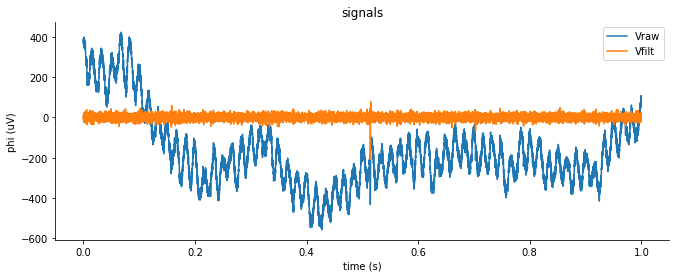

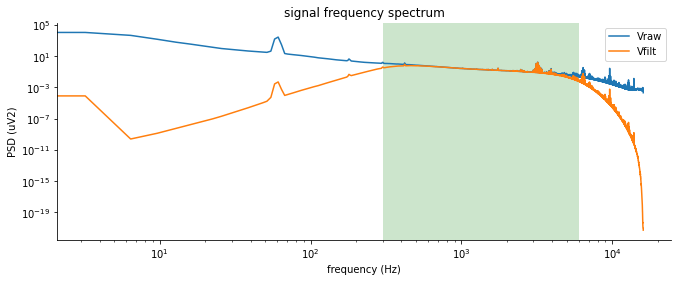

In [5]:
# Apply band-pass filter
fbounds = [300., 6000]  # Hz
data['Vfilt'] = filter_signal(data['Vraw'], fs, fbounds)
# Plot signals within defined time window
fig = plot_signals(data, tbounds=[0, 1])
# Plot frequency spectra
fig2 = plot_frequency_spectrum(data, band=fbounds)

### Questions:

- *What can you say about the effect of the filter onf the signal?*
- *What about its effect on the signal frequency spectrum?*
- *Do you see any obvious spikes on the filtered signal?*

## Step 3: Extract spikes from the filtered signal

Now that we have a clean spike channel we can identify and extract spikes. We do so by:
- computing an absolute detection threshold from the filtered signal properties
- detecting negative peaks in the filtered signal that are below the fixed threshold
- extracting each candidate spike a signal window around its peak

 13/02/2025 12:14:25: detecting peaks in signal beyond -70.95 uV threshold...
 13/02/2025 12:14:25: extracting spikes from [-38  57] samples window around each peak...
 13/02/2025 12:14:25: 3615 spikes detected
 13/02/2025 12:14:25: plotting 3615 spike traces...


100%|██████████| 3615/3615 [00:01<00:00, 3086.89it/s]


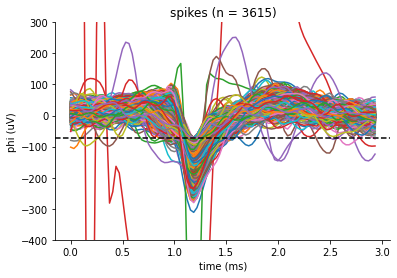

In [6]:
# Estimate standard deviation of background noise
sigma_noise = np.median(np.abs(data['Vfilt']) / 0.6745)  # uV
# Derive absolute detection threshold
Vthr = 6 * sigma_noise  # uV
# Detect peaks and extract spikes around peaks
wspike = 3e-3  # spike window length (s)
ispikes, spikes = get_spikes(data['Vfilt'].values, Vthr, wlen=wspike * fs)
# Plot detected spikes
fig = plot_spikes(spikes, fs, thr=Vthr)

As we can see, out algorithm did a good job at detecting physiological spikes, but it also detected a few artifactual spikes of aberrant amplitude along the way.

Thankfully, we can easily get rid of these artifactual spikes using a simple amplitude filtering:   

 13/02/2025 12:14:28: discarding spikes outside of {Vbounds} interval...
 13/02/2025 12:14:28: filtered out 4 spikes
 13/02/2025 12:14:28: plotting 3611 spike traces...


100%|██████████| 3611/3611 [00:01<00:00, 3295.18it/s]


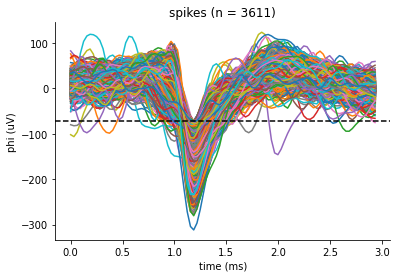

In [7]:
Vbounds = (-350., 180.)
ispikes, spikes = filter_spikes(ispikes, spikes, Vbounds)
fig = plot_spikes(spikes, fs, thr=Vthr)

Much better! We now see only spikes that appear to be of physiological origin. Moreover, their amplitude seem to vary quite a lot, which might indicate the presence of multiple spiking units (i.e., neurons).

To get a better idea of the data spikes population, we will plot a subset of 100 randomly selected spikes. In parallel, we can also visualize detected spikes atop of the filtered recording:

 13/02/2025 12:14:31: plotting 100 randomly selected spike traces...
 13/02/2025 12:14:31: plotting signals...


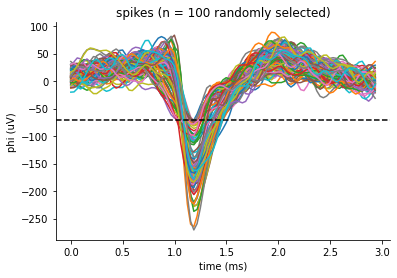

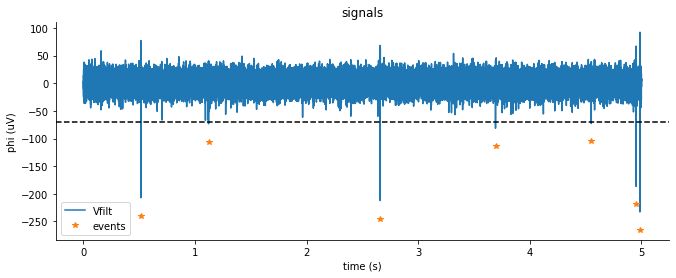

In [8]:
fig = plot_spikes(spikes, fs, thr=Vthr, n=100)
fig2 = plot_signals(data, keys='Vfilt', tbounds=[0, 5], events=ispikes, thr=Vthr)

### Questions:

- *Based on the above observations, what can you say about the spike waveform distribution?*
- *How many spiking units do you think there are? Could they be differentiated?* 

## Step 4: Extract features from detected spikes

In order to classify our spikes we need some features to work with. These features could be arbitrarily extracted form the spikes waveforms, e.g. by chosing the peak amplitude of the spike or the width of the waveform.

A more principled way to extract such features is to use ***Principal Component Analysis (PCA)***. PCA is a dimensionality reduction technique commonly used in neuroscience (and machine learning to a greater extent), when we wish to classify observations that are high-dimensional in nature (such as events in a detailed timeseries). Simply put, PCA projects each data observation (in our case, spike) on to a lower-dimensional subspace that captures *most of the variance* seen across the different observations (i.e. spikes). The dimensions of this subpace (so-called *principal components*) represent linear combinations (or *features*) of the original observations.

Despite its apparent complexity, this algorithm only consists of a few linear algebra transformations (which we will not detail here).

### Questions:
- *In our case, what is a principal component made of?*
- *What will a particular point in the PC space correspond to?*


Let's apply PCA on our spike dataset (specifying a projection to 10 PCs), and plot the projection of each spike on to the first 3 principle components:

 13/02/2025 12:14:31: applying PCA on (3611, 95) dataset...
 13/02/2025 12:14:32: plotting distribution of first principal components...


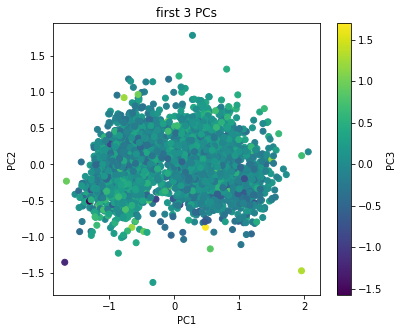

In [9]:
PCs_per_spike = pca(spikes)
fig = plot_principal_components(PCs_per_spike)

### Questions:

- *What can you say about the distribution of the spike population in the PC space?*
- *Do you see diffferent clusters emerging?*

## Step 5: Classify spikes acccording to their features

Now that we projected our spikes dataset onto a low-dimensional "features" subspace, we can try to classify the spikes, i.e. *assign each spike occurence to a particular spiking unit*.

To this aim, we will use a simple *k-means* clustering algorihm (also a classic in the fields of neuroscience and machine learning). Simply put, the *k-means* algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean of the samples in the cluster.

This algorithm performs in successive steps:
1. *Initialization*: a set of $K$ centroids is randomly initiated in the data space
2. *Assignment*: Each data point is assigned to the cluster of the centroid closest to it
3. *Update*: the coordinates of each centroid is re-evaluated as the center of its cluster

Notably, steps 2 and 3 are carried out iteratively until a convergence is reached. 

Again, this algorithm can be implemented in just a few lines of code (although that is not the scope of this tutorial).

### Basic k-means with 2 clusters

Let's start with the simplest case, and try to classify our spikes into 2 different clusters:

 13/02/2025 12:14:32: applying k-means clustering with 2 clusters...
 13/02/2025 12:14:32: plotting distribution of first principal components...
 13/02/2025 12:14:32: plotting average spike traces for 2 clusters...


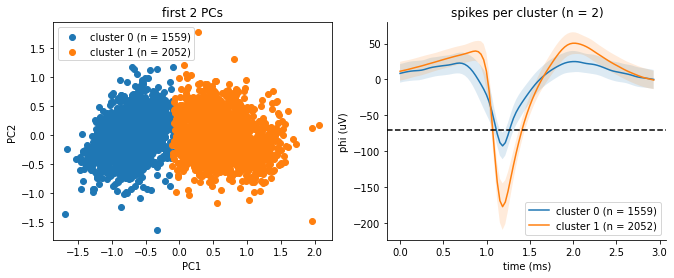

In [10]:
n_clusters = 2
clusters = kmeans(PCs_per_spike, n_clusters=n_clusters)
fig = plot_PCs_and_spikes_per_cluster(PCs_per_spike, spikes, clusters, fs, Vthr=Vthr)

### Questions

- *What can you say about the performance of the k-means algorithm to segregate data in the PC space?*
- *What about the resulting spike waveforms for each cluster?*
- *Based on the segregation pattern, what do you think PC1 encodes for?*
- *Do you think we captured all the possible "classes" of spike waveforms present in the recording?*
- *Do you think all identified clusters correspond to a "real" spiking unit?*

### Varying the number of clusters

In effect, it is hard to predict how many spiking units there are in a given recording. So *how should we choose the number of clusters?*

One way to go around that is to run our k-means function many times with different cluster numbers, and look at the resulting clustered waveforms:

 13/02/2025 12:14:32: applying k-means clustering with 2 clusters...
 13/02/2025 12:14:32: plotting distribution of first principal components...
 13/02/2025 12:14:32: plotting average spike traces for 2 clusters...
 13/02/2025 12:14:32: applying k-means clustering with 3 clusters...
 13/02/2025 12:14:32: plotting distribution of first principal components...
 13/02/2025 12:14:32: plotting average spike traces for 3 clusters...
 13/02/2025 12:14:32: applying k-means clustering with 4 clusters...
 13/02/2025 12:14:32: plotting distribution of first principal components...
 13/02/2025 12:14:32: plotting average spike traces for 4 clusters...
 13/02/2025 12:14:32: applying k-means clustering with 5 clusters...
 13/02/2025 12:14:32: plotting distribution of first principal components...
 13/02/2025 12:14:32: plotting average spike traces for 5 clusters...


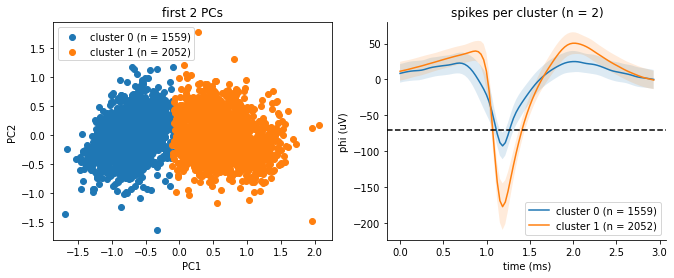

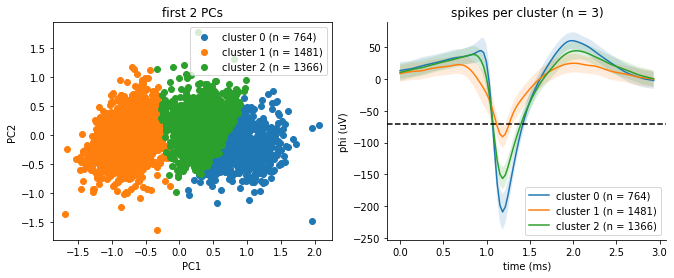

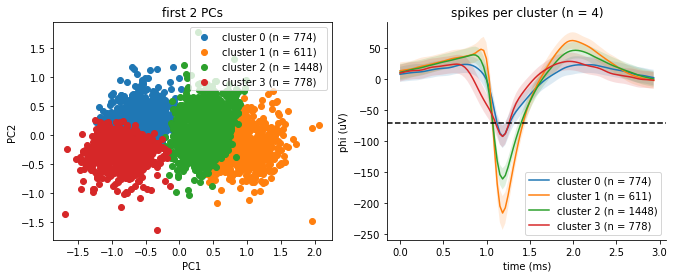

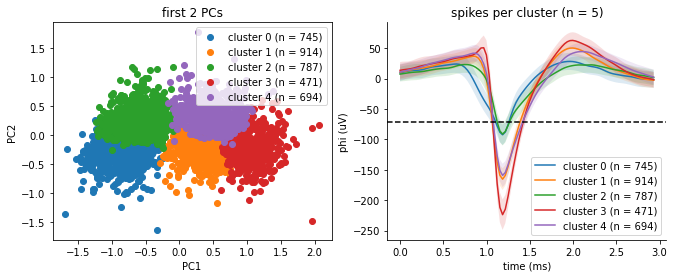

In [11]:
for n_clusters in range(2, 6):
    clusters = kmeans(PCs_per_spike, n_clusters=n_clusters)
    fig = plot_PCs_and_spikes_per_cluster(PCs_per_spike, spikes, clusters, fs, Vthr=Vthr)

### Questions:

- *Based on the segregation pattern for the n > 2 clusters case, what do you think PC2 encodes for?*
- *Based on the above results, what would you say is the "true" number of clusters?*
- *Which clusters correspond to "real" spiking units, and which are due to noise?*

## Final step: visualize the activity of each identified spiking unit

The successive k-means clusterings performed above seem to reveal the presence of **3 clearly differentiable clusters in the PC space**. In fact, using a higher number of clusters yielded a strong redundancy in the spike waveforms across clusters.

The 3 clusters can be described as follows:
- 1 cluster with a *just-above-threshold* spike waveform, probably corresponding to noise-driven random threshold crossings
- 1 cluster with an *intermediate* spike amplitude (peak around -160 uV)
- 1 cluster with an *large* spike amplitude (peak around -220 uV)

The last 2 clusters are likely attributable to real spiking units.

Hence, now that we are reasonably confident about the number of clusters, we can perform a final data classification in order to visualize the spike waveforms of our 2 units and where they were detected on the filtered recording:

 13/02/2025 12:14:34: applying k-means clustering with 3 clusters...
 13/02/2025 12:14:34: plotting distribution of first principal components...
 13/02/2025 12:14:34: plotting average spike traces for 3 clusters...
 13/02/2025 12:14:34: plotting signals...


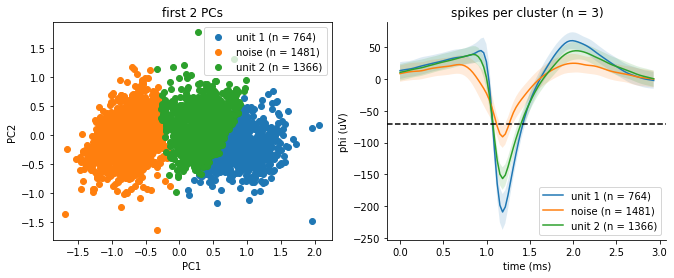

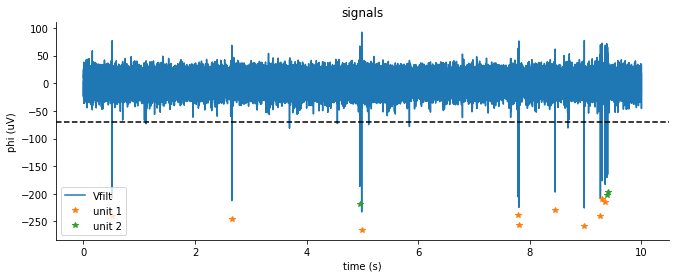

In [12]:
# Perform k-mean with 3 clusters
n_clusters = 3
clusters = kmeans(PCs_per_spike, n_clusters=n_clusters)
# Identify noise cluster from spike amplitude
avg_neg_peak_per_cluster = {i: spikes[clusters==i, :].mean(axis=0).min() for i in clusters}
inoise_cluster = max(avg_neg_peak_per_cluster, key=avg_neg_peak_per_cluster.get)
# Label clusters as units and noise
labels = [f'unit {i + 1}' for i in range(n_clusters - 1)]
labels.insert(inoise_cluster, 'noise')
labels = dict(zip(range(n_clusters), labels))
# Plot PCs and spikes for each group
fig = plot_PCs_and_spikes_per_cluster(PCs_per_spike, spikes, clusters, fs, Vthr=Vthr, labels=labels)
# Plot spike events for each unit
del labels[inoise_cluster]
ispikes_per_unit = {v: ispikes[np.where(clusters == k)[0]] for k, v in labels.items()}
fig2 = plot_signals(data, keys='Vfilt', tbounds=[0, 10], events=ispikes_per_unit, thr=Vthr)

## Conclusions

This tutorial should give you an overall idea of the processing steps and algorithms involved in spike detection and spike sorting from extracellular neural signals. In particular, you should now be familiar with:
- The various signal components that make up raw extracellular recordings
- How to effectively remove them noise source from such signals
- How to effectively detect spikes from cleaned recordings 
- How to use dimensionality reduction techniques to automatically detect discriminative features in detected spikes
- How to use clustering algorithms to classify detected spikes into noise and different spiking units